In [1]:
# Calcula el onset en la Cuenca del Valle
# de México con información del CPC NOAA.

import os


import pandas as pd
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

# Permite ajustar losva lores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

In [2]:
# Datos.
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"
path_cpc = path_d  + "CPC_Pre/cuenca_valle_mexico/"
fname_cpc = "cuenca_valle_mexico_precip.nc"
fname_grid = "grid_points.csv"

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r): os.mkdir(path_r)

year_r = [1981, 2020]
# Fechas límite de inicio y fin de onset y withdrawal.
ini = [ [121, 196], [254, 323] ]
# Utilizar el onset al inicio o al final de la racha de precipitación.
rec = [True, False]
lim = 6
step = [0.5, 0.05]

df_pre = pd.read_csv(path_d + "pre_daily_CHIRPS.csv", index_col = "time" )
df_pre.index = pd.to_datetime( df_pre.index )
date_pre = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año")
for i in [0, 1]: date_pre.iloc[:, i] = pd.to_datetime( date_pre.iloc[:, i] )

# Se leen los límites de la cuenca.
df_grid = pd.read_csv(path_d + fname_grid)
lon_i = 360 + df_grid.lon.min()
lon_f = 360 + df_grid.lon.max() + 0.5
lat_i = df_grid.lat.min()
lat_f = df_grid.lat.max() + 0.5

# Se carga la precipitación.
pre_xr = xr.load_dataset(path_cpc + fname_cpc)
# Se recorta la zona de estudio.
pre_xr = pre_xr.sel( dict( lon = np.arange(lon_i, lon_f, 0.5),
    lat = np.arange(lat_i, lat_f, 0.5) ) )

# Quitamos los 29 de febrero.
pre_xr = ( pre_xr.sel( time=~( (pre_xr.time.dt.month == 2)
    & (pre_xr.time.dt.day == 29) ) ) )

# Escogemos los años a partir de 1981.
pre_xr  = pre_xr.sel( time = ( pre_xr.time.dt.year > 1980 ) )

# Cantidad de días a promediar.
d = 20

df_mean = pre_xr.mean(["lat", "lon"]).to_dataframe()
df_mean.columns = ["Cuenca"]

# Media móvil.
df_mean = df_mean.iloc[-d:,:].append( df_mean.append( df_mean.iloc[0:d,:] ) )
df_mean = df_mean.rolling(d, center = True).mean()
df_mean = df_mean.iloc[d:-d,:]

Umbral: 2.5 mm/día, 20 días consecutivos, Pendiente: 0.312
Umbral: 1.7 mm/día, 20 días consecutivos, Pendiente: -0.397


,Cuenca - Onset,Cuenca - Withdrawal,Cuenca - Length,Onset - date,Withdrawal - date
count,40.000000,40.000000,40,1970-02-10 00:00:00.000000000,1970-02-10 00:00:00.000000000
mean,152.675000,288.925000,136 days 06:00:00,1970-06-02 16:12:00.000000000,1970-10-16 22:12:00.000000000
std,13.625744,16.058207,22 days 12:04:43.056315855,1970-01-14 15:01:04.274886092,1970-01-17 01:23:49.121349710
min,121.000000,257.000000,91 days 00:00:00,1970-05-02 00:00:00.000000000,1970-09-15 00:00:00.000000000
25%,144.000000,277.750000,118 days 12:00:00,1970-05-25 00:00:00.000000000,1970-10-05 18:00:00.000000000
50%,154.500000,288.000000,135 days 12:00:00,1970-06-04 12:00:00.000000000,1970-10-16 00:00:00.000000000
75%,163.500000,301.750000,150 days 00:00:00,1970-06-13 12:00:00.000000000,1970-10-29 18:00:00.000000000
max,173.000000,322.000000,193 days 00:00:00,1970-06-23 00:00:00.000000000,1970-11-19 00:00:00.000000000


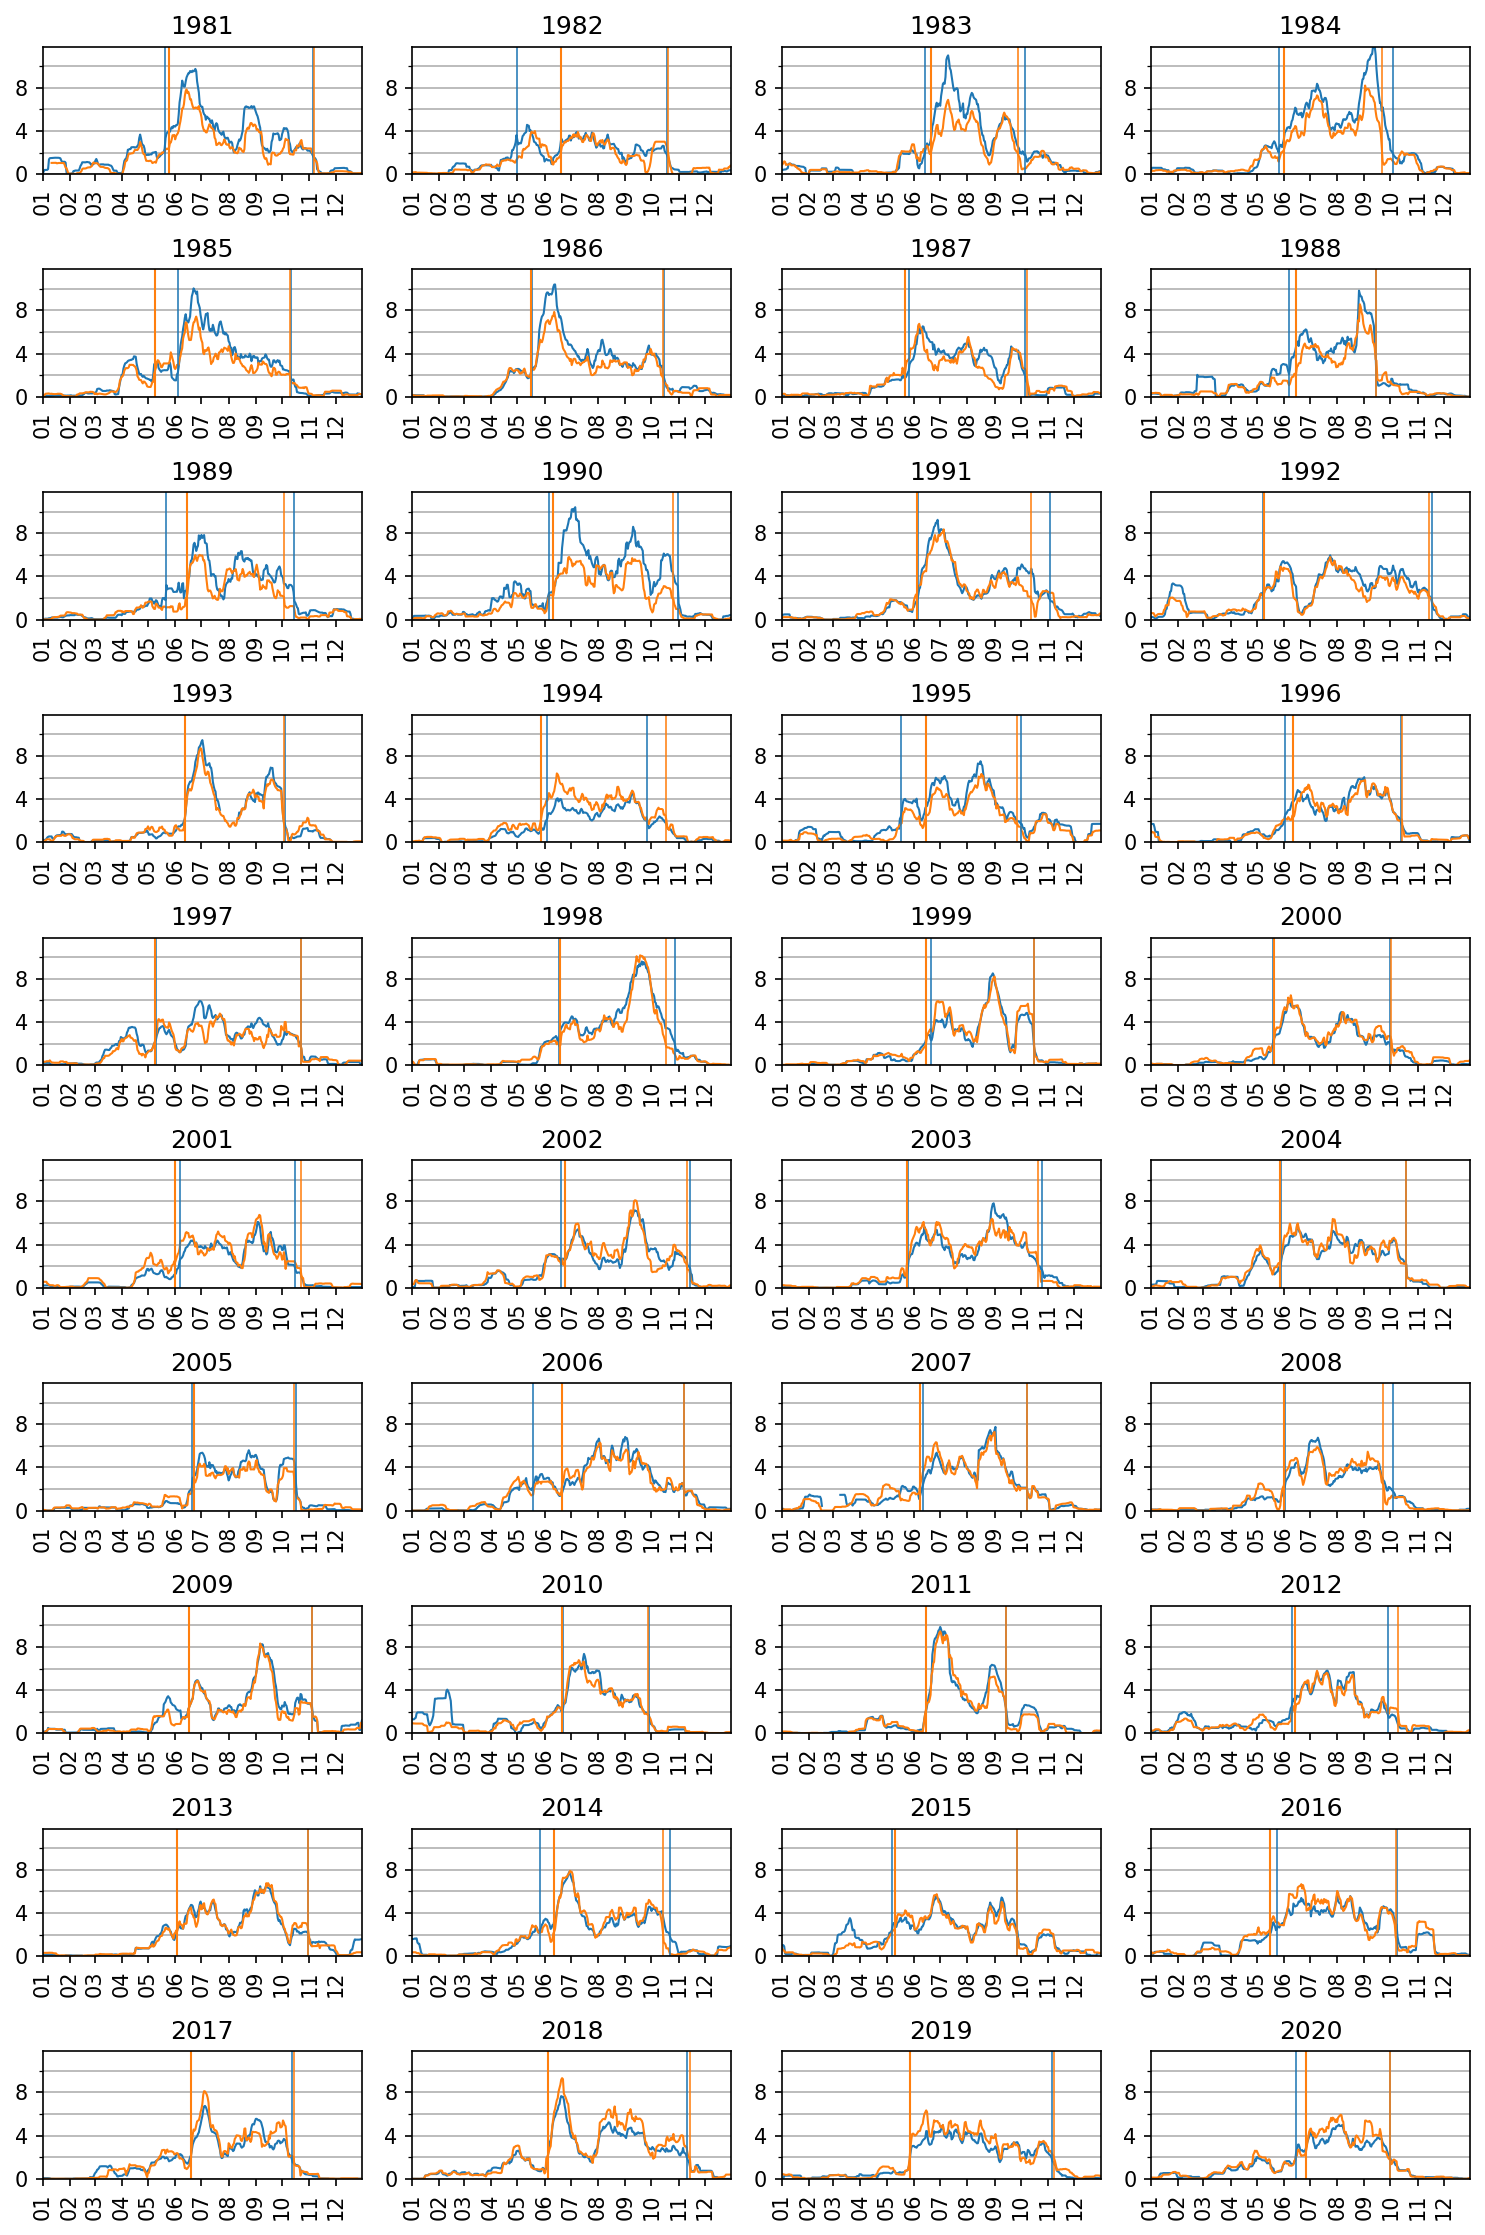

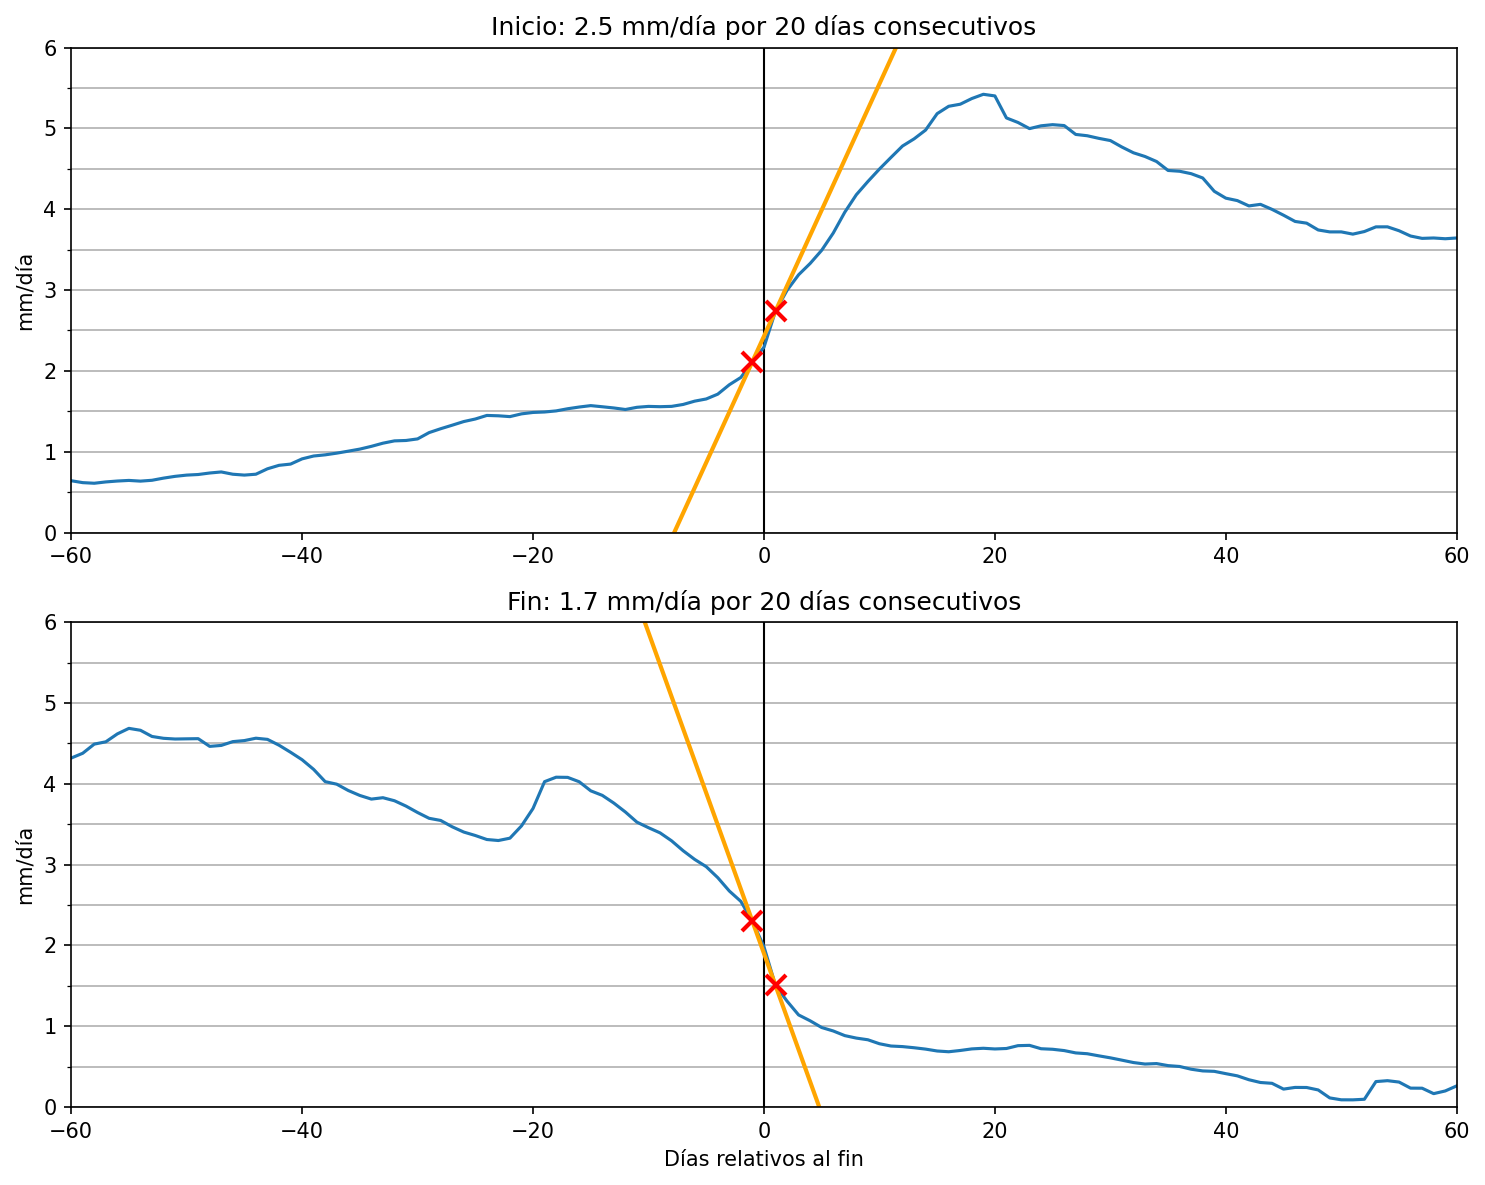

In [3]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [2.5, 1.7]
n = [20, 20]
# Inicio o fin de la racha de precipitación.
k = [0, 0]
for i in range( len(rec) ):
    if rec[i]:
        k[i] = n[i]
onset_n = ["Inicio", "Fin"]

df_mean_ind = pd.DataFrame( df_mean.copy(), columns = ["Cuenca"] )

years = range(year_r[0], year_r[1] + 1)
c = "Cuenca"
title = "onset_withdrawal_CPC.png"

# Onset.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[0]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral[0], inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(df_mean_ind[p] == umbral[0], 0)
    df_mean_ind[p] = df_mean_ind[p].where(df_mean_ind[p] < umbral[0], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n[0]):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n[0], 0 )
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] < n[0], 1 )
df_mean_ind[ind] = df_mean_ind[ind].where(
    df_mean_ind.index.month.isin( range(5, 12) ), 0 )
df_mean_ind.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & ( df_mean_ind.index.dayofyear > ( ini[0][0] + k[0] - 1 ) )
        & ( df_mean_ind.index.dayofyear < ( ini[0][1] + k[0] + 1 ) ) ]
    row = []
    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( None )
    # Agregamos la fila al DataFrame.
    date = date.append([row])
# Recorremos al inicio de la racha de días de precipitación.
if rec[0]: date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n[0], 'D')

# Withdrawal.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[1]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral[1], inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(df_mean_ind[p] == umbral[1], 0)
    df_mean_ind[p] = df_mean_ind[p].where(df_mean_ind[p] <  umbral[1], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n[1]):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n[1], 0 )
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] < n[1], 1 )
df_mean_ind[ind] = df_mean_ind[ind].where(
    df_mean_ind.index.month.isin( range(5, 12) ), 0 )
df_mean_ind.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date_2 = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & ( df_mean_ind.index.dayofyear > ( ini[1][0] - k[1] - 1 ) )
        & ( df_mean_ind.index.dayofyear < ( ini[1][1] - k[1] + 1 ) ) ]
    row = []
    # Fechas.
    row.append( None )
    #row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    # Agregamos la fila al DataFrame.
    date_2 = date_2.append([row])
# Recorremos al inicio de la racha de días de precipitación.
if rec[1]: date_2.iloc[:, 1] = date_2.iloc[:, 1] + np.timedelta64(n[1], 'D')

# Unimos onset y withdrawal.
date.iloc[:, 1] = date_2.iloc[:, 1]

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"

# Longitud de la temporada.
date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
shift_2 = date.iloc[:, 1].apply(lambda x: x.dayofyear)

# Guarda las series de tiempo.
date.to_csv(path_d + "onset_CPC.csv")
shift.to_csv(path_d + "shift_CPC.csv")
shift_2.to_csv(path_d + "shift_withdrawal_CPC.csv")

year = range(year_r[0], year_r[1] + 1)

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]


for i in range( len(year) ):
    df_year = df_mean_ind[ df_mean_ind.index.year == year[i] ]
    df_year_2 = df_pre[ df_pre.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    # Fechas.
    onset_pre = date_pre.iloc[date_pre.index == year[i], 0]
    withdrawal_pre = date_pre.iloc[date_pre.index == year[i], 1]

    axes[i].plot(   df_year.iloc[:, 0], linewidth = 1, color = "tab:blue"   )
    axes[i].plot( df_year_2.iloc[:, 0], linewidth = 1, color = "tab:orange" )

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "tab:blue", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (0, 12), 
        color = "tab:blue", linewidth = 0.75 ) 

    # Onset.
    axes[i].plot( (onset_pre, onset_pre), (0, 12),
        color = "tab:orange", linewidth = 1 )
    # Withdrawal.
    axes[i].plot( (withdrawal_pre, withdrawal_pre), (0, 12), 
        color = "tab:orange", linewidth = 0.75 ) 

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim( df_mean.min().values[0], df_mean.max().values[0])
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig( path_r + title )


# Composite.

# Cantidad de días a recorrer.
delta = shift.max()
delta_2 = shift_2.max()
shift = delta - shift
shift_2 = delta_2 - shift_2

# Graficamos.
fig, axes = plt.subplots(2)
fig.set_facecolor("w")
fig.set_size_inches(10, 8)
fig.set_dpi(150)

shift_o = [shift, shift_2]
delta_o = [delta, delta_2]

# Creamos un DataFrame con año
# como columnas y días como filas.
pre_df = pd.DataFrame( df_mean.copy(), columns = [ df_mean.columns[0] ] )
pre_df["Año"] = pre_df.index.year
pre_df["Día"] = pre_df.index.dayofyear

# Convertimos los años a columnas.
pre_df = pre_df.pivot(index = "Día", columns = "Año")
pre_df.columns = pre_df.columns.droplevel(0)

# Eliminamos el 2021.
pre_df = pre_df.iloc[:, :-1]

for i in [0, 1]:
    pre_df_2 = pre_df.copy()

    # Alineamos las series de tiempo.
    for j in pre_df_2.columns:
        pre_df_2[j] = pre_df_2[j].shift(shift_o[i][j])

    # Promediamos y seleccionamos 120 días.
    pre_df_2 = pre_df_2.mean(axis = 1)
    if i == 1:
        a = pre_df_2[0:60]
        a.index = np.arange(367, 367 + 60)
        pre_df_2 = pre_df_2.append(a)
    pre_df_2 = pre_df_2.loc[delta_o[i] - 60: delta_o[i] + 60]
    pre_df_2.index = range(-60, 61)

    # Graficamos.
    axes[i].plot( (0, 0), (0, 7), color = "k", linewidth = 1 )
    pre_df_2.plot(ax = axes[i])

    axes[i].set_title( ( f"{onset_n[i]}: {umbral[i]} "
        + f"mm/día por {n[i]} días consecutivos" ) )
    axes[i].set_xlim(-60, 60)
    axes[i].set_ylim(0, lim)

    # Pendiente del incremento de lluvia.
    y_1 = pre_df_2.loc[-1]
    y_2 = pre_df_2.loc[ 1]
    x_1 = -1
    x_2 =  1
    m = ( y_1 - y_2 ) / ( x_1 - x_2 )
    print( f"Umbral: {umbral[i]} mm/día, {n[i]} días consecutivos, " + 
        f"Pendiente: {m:.3f}" )
    axes[i].plot( ( x_1 + ( 0 - y_1 ) / m, 
        x_1 + ( lim - y_1 ) / m ), (0, lim),
        color = "orange", linewidth = 2 )
    axes[i].plot( x_1, y_1, marker = "x",
        markersize = 10, mew = 2, color = "r" )
    axes[i].plot( x_2, y_2, marker = "x",
        markersize = 10, mew = 2, color = "r" )

    axes[i].set_ylabel("mm/día")
    if i == 1: axes[i].set_xlabel( "Días relativos al " + onset_n[i].lower() )

    for ax in axes.flatten():
        ax.set_yticks( np.arange(0, lim, step[0]), minor = True )
        ax.grid( visible = True, which = "both", axis ="y" )

    # Separación adecuada entre gráficas.
    fig.tight_layout()

    # Guardamos el archivo.
    #fig_s[i].savefig( path_r + title )

date_2 = date.copy()
date_2.iloc[:, 0] = date_2.iloc[:, 0].apply(lambda x: x.dayofyear)
date_2.iloc[:, 1] = date_2.iloc[:, 1].apply(lambda x: x.dayofyear)

stats = date_2.describe()

stats["Onset - date"] = pd.to_datetime(stats.iloc[:, 0], unit = "D")
stats["Withdrawal - date"] = pd.to_datetime(stats.iloc[:, 1], unit = "D")

stats

Diferencia de días:-3.8
Diferencia de días:1.4
Onset correlation: 0.600
Withdrawal correlation: 0.909


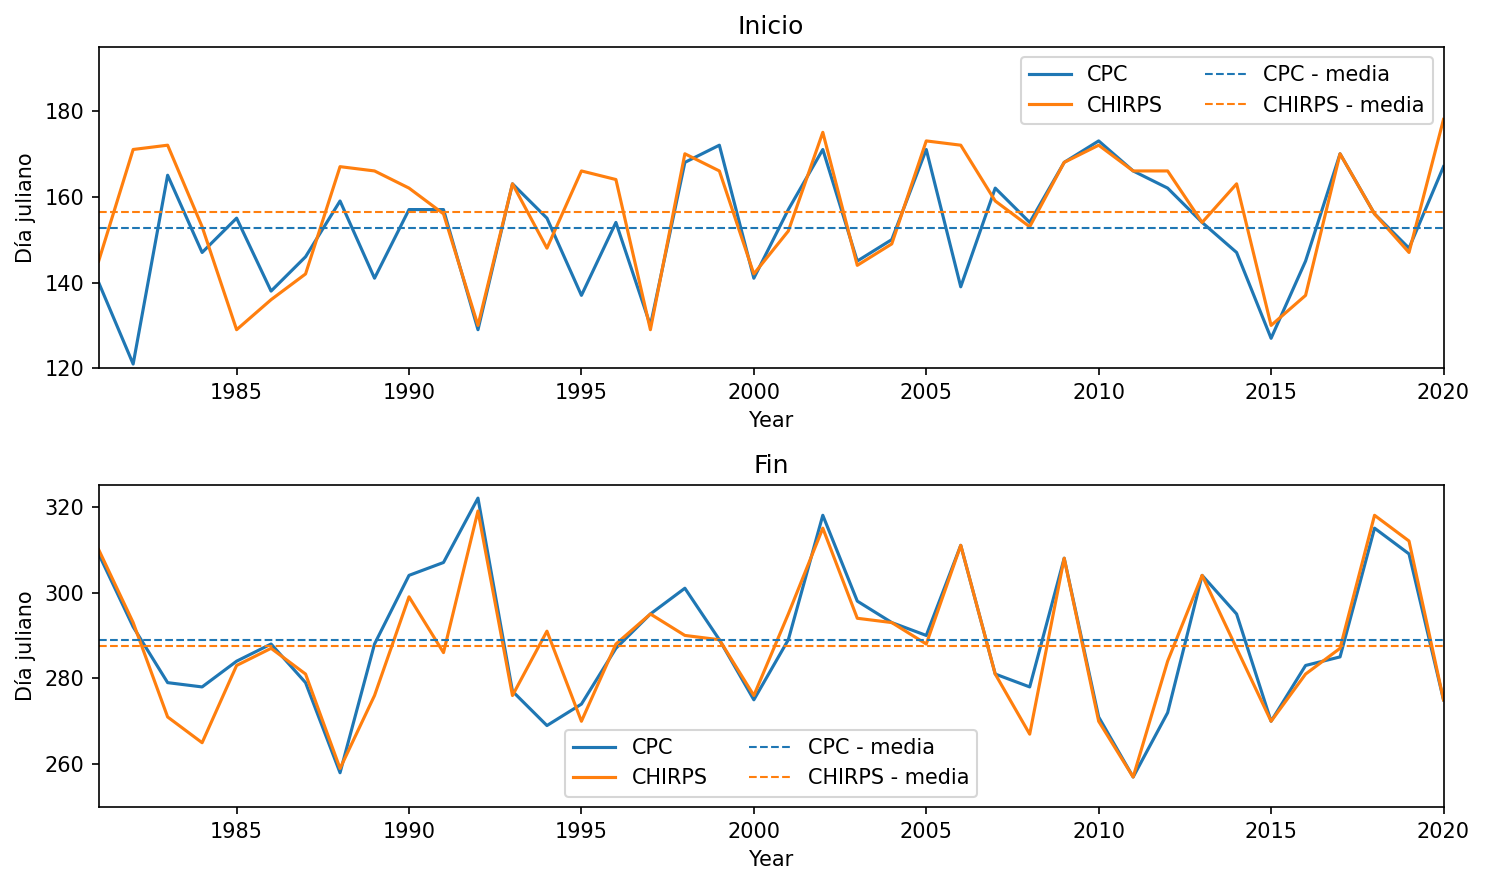

In [4]:
# Serie de tiempo de CPC.
CPC = pd.read_csv(path_d + "onset_CPC.csv", index_col = "Año")

# Se convierten las fechas a días julianos.
CPC["Cuenca - Onset"] = CPC["Cuenca - Onset"].apply(
    lambda x: pd.to_datetime(x))
CPC["Cuenca - Onset"] = CPC["Cuenca - Onset"].apply(
    lambda x: x.dayofyear)
CPC["Cuenca - Withdrawal"] = CPC["Cuenca - Withdrawal"].apply(
    lambda x: pd.to_datetime(x))
CPC["Cuenca - Withdrawal"] = CPC["Cuenca - Withdrawal"].apply(
    lambda x: x.dayofyear)

# Serie de tiempo de CHIRPS.
CHIRPS = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año")

# Se convierten las fechas a días julianos.
CHIRPS["Cuenca - Onset"] = CHIRPS["Cuenca - Onset"].apply(
    lambda x: pd.to_datetime(x))
CHIRPS["Cuenca - Onset"] = CHIRPS["Cuenca - Onset"].apply(
    lambda x: x.dayofyear)
CHIRPS["Cuenca - Withdrawal"] = CHIRPS["Cuenca - Withdrawal"].apply(
    lambda x: pd.to_datetime(x))
CHIRPS["Cuenca - Withdrawal"] = CHIRPS["Cuenca - Withdrawal"].apply(
    lambda x: x.dayofyear)

#CPC = CPC.drop(1982)
#CHIRPS = CHIRPS.drop(1982)
#CPC = CPC.drop(1985)
#CHIRPS = CHIRPS.drop(1985)

# Graficamos.
fig, ax = plt.subplots(2)
fig.set_facecolor("w")
#fig.set_size_inches(10, 12)
fig.set_size_inches(10, 6)
fig.set_dpi(150)

corr = []
for i in range(len(ax)):
    # Series de tiempo.
    CPC.iloc[:, i].plot(ax = ax[i])
    CHIRPS.iloc[:, i].plot(ax = ax[i])

    # Medias.
    ax[i].plot( (1981, 2020), (CPC.iloc[:, i].mean(),)*2,
        color = "tab:blue", linestyle = "dashed", linewidth = 1 )
    ax[i].plot( (1981, 2020), (CHIRPS.iloc[:, i].mean(),)*2,
        color = "tab:orange", linestyle = "dashed", linewidth = 1 )

    print( "Diferencia de días:"
        + f"{CPC.iloc[:, i].mean() - CHIRPS.iloc[:, i].mean():.1f}" )

    # Formato de ejes.
    ax[i].set_ylabel("Día juliano")
    ax[i].legend( ["CPC", "CHIRPS", "CPC - media",
        "CHIRPS - media"], ncol = 2 )
    ax[i].set_xlabel("")
    ax[i].set_xlim(1981, 2020)
    ax[i].set_xlabel("Year")

    # Correlaciones de las series.
    corr.append( CPC.iloc[:, i].corr( CHIRPS.iloc[:, i] ) )

ax[0].set_ylim(120, 195)
ax[0].set_title("Inicio")
ax[1].set_ylim(250, 325)
ax[1].set_title("Fin")

print(f"Onset correlation: {corr[0]:.3f}")
print(f"Withdrawal correlation: {corr[1]:.3f}")

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "comparacion.png")